## Plan of work <a id = "plan"> </a>

[1. Downloading and preparing data](#1.)<br>
[2. Train the model](#2.)<br>
[3. Final testing](#3.)<br>

In [17]:
import numpy as np 
import pandas as pd 

import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import contractions

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# from multiprocessing import Pool
import time

from pathlib import Path

# Get project path
project_path = Path.cwd().resolve().parent.parent.parent

# 1. Downloading and preparing data <a id = "1."> </a>

[Back to plan](#plan)

In [2]:
# DataFrame with Train Data
train_df = pd.read_csv(f'{project_path}/Output/train_data.csv', index_col=0)

In [3]:
#  The Function for text preprocessing
def tokenize_string(text):

    # Before lemmatizing replace all constructions with normal words
    text_upd = contractions.fix(text)

    # Tokenize the data and use only lower letters
    words = word_tokenize(text_upd.lower())
    
    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos = "v") for word in words] 
    
    # # Get rid of punctuation
    words = [word for word in lemmas if word not in string.punctuation]
    
    # Remove stop words
    # Stop words corpus (179 in total)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return words

In [4]:
# Tokenizing the series for train data
print('I have just started updatind train_df')
start = time.time()
train_df['Preprocessed_text'] = train_df.question_text.apply(tokenize_string)
finish = time.time()

print('Time spent:', int((finish - start)//60), 'min, ', round((finish - start)%60), 'sec')

I have just started updatind train_df
Time spent: 5 min,  12 sec


In [5]:
y_train = train_df.target.values

In [6]:
word2vec_model = Word2Vec(train_df['Preprocessed_text'], vector_size=700, window=5, min_count=5)

In [9]:
# Function for preprocessing the whole phrase instead of separate phrases
def phrase_vector(word2vec_model, phrase):
    phrase = [word for word in phrase if word in word2vec_model.wv.key_to_index]
    
    if len(phrase) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    return np.mean(word2vec_model.wv[phrase], axis=0)

In [8]:
X_train = np.expand_dims(np.array([phrase_vector(word2vec_model, phrase) for phrase in train_df['Preprocessed_text']]), axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 2. Train the model <a id = "2."> </a>

[Back to plan](#plan)

In [11]:
# BiDirectionalLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(1, X_train.shape[-1])))   
model.add(Bidirectional(LSTM(128, return_sequences=True)))    
model.add(Bidirectional(LSTM(64, return_sequences=True))) 
model.add(Bidirectional(LSTM(32))) 
model.add(Dense(1, activation='sigmoid'))

checkpoint_filepath = 'tmp/checkpoint/model_best.h5'

model_callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1)
]

In [12]:
# Compile and train the model
model.compile(loss='BinaryFocalCrossentropy', optimizer='adam', metrics=['AUC'])
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
unique_classes = np.unique(y_train)
class_weights = {cls: 1.0/np.mean(class_weights[y_train==cls]) for cls in unique_classes}

In [13]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, 
          class_weight=class_weights, callbacks = model_callbacks)

Epoch 1/10
26122/26123 [============================>.] - ETA: 0s - loss: 0.0105 - auc: 0.9333
Epoch 1: val_auc improved from -inf to 0.94134, saving model to tmp/checkpoint/model_best.h5
26123/26123 [==============================] - 393s 15ms/step - loss: 0.0105 - auc: 0.9333 - val_loss: 0.0581 - val_auc: 0.9413
Epoch 2/10
26120/26123 [============================>.] - ETA: 0s - loss: 0.0098 - auc: 0.9450
Epoch 2: val_auc improved from 0.94134 to 0.94403, saving model to tmp/checkpoint/model_best.h5
26123/26123 [==============================] - 384s 15ms/step - loss: 0.0098 - auc: 0.9450 - val_loss: 0.0577 - val_auc: 0.9440
Epoch 3/10
26122/26123 [============================>.] - ETA: 0s - loss: 0.0095 - auc: 0.9491
Epoch 3: val_auc improved from 0.94403 to 0.94522, saving model to tmp/checkpoint/model_best.h5
26123/26123 [==============================] - 387s 15ms/step - loss: 0.0095 - auc: 0.9491 - val_loss: 0.0611 - val_auc: 0.9452
Epoch 4/10
26121/26123 [======================

In [14]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

# 3. Final testing <a id = "3."> </a>

[Back to plan](#plan)

In [36]:
def conf_matrix(target, predicted):
    cm = confusion_matrix(y_target=target, 
                          y_predicted=predicted)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10, 10), 
                                    show_absolute=True, show_normed=True, colorbar=True)
    plt.show()

def eval_predictions(model, features_train, target_train, features_valid, target_valid):
    predictions = model.predict(features_valid).flatten()
    threshold = np.percentile(predictions, 93)
    y_pred = np.where(predictions > threshold, 1, 0)
    print('F1-score for class (1): {:.2f}'. format(f1_score(target_valid, y_pred)))
    print('Matthews coefficient: {:.2f}'. format(matthews_corrcoef(target_valid, y_pred)))
    print('Accuracy: {:.2f}'. format(accuracy_score(target_valid, y_pred)))
    print('Balanced accuracy: {:.2f}'. format(balanced_accuracy_score(target_valid, y_pred)))
    print(classification_report(target_valid, y_pred, labels=[0,1]))
    roc(model, features_valid, target_valid)
    conf_matrix(target_valid, y_pred)
    return model

def roc(model, features_valid, target_valid):
    #Working out the fpr and tpr
    probabilities_valid = model.predict(features_valid)
    probabilities_one_valid = probabilities_valid.flatten()
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)
    fig, ax = plt.subplots(1, 2, figsize = (15,10))
    
    # ROC-curve of our model
    ax[0].plot(fpr, tpr, linestyle='-')
    # ROC-curve of a random model
    ax[0].plot([0, 1], [0, 1], linestyle='--')
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    ax[0].set_xlabel('False Positive Rate') 
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC-кривая')
    
    # PR-curve of our model
    ax[1].plot(recall, precision)
    ax[1].set_xlim(0,1)
    ax[1].set_ylim(0,1)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR-кривая')
    
    plt.show()
    # calculate AUROC
    print('AUROC: {:.2f}'.format(roc_auc_score(target_valid, probabilities_one_valid)))
    # calculate AUPRC
    print ('AUPRC: {:.2f}'.format(average_precision_score(target_valid, probabilities_one_valid)))

8164/8164 [==============================] - 14s 2ms/step
F1-score for class (1): 0.60
Matthews coefficient: 0.57
Accuracy: 0.95
Balanced accuracy: 0.80
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    245063
           1       0.57      0.64      0.60     16162

    accuracy                           0.95    261225
   macro avg       0.77      0.80      0.79    261225
weighted avg       0.95      0.95      0.95    261225

8164/8164 [==============================] - 15s 2ms/step


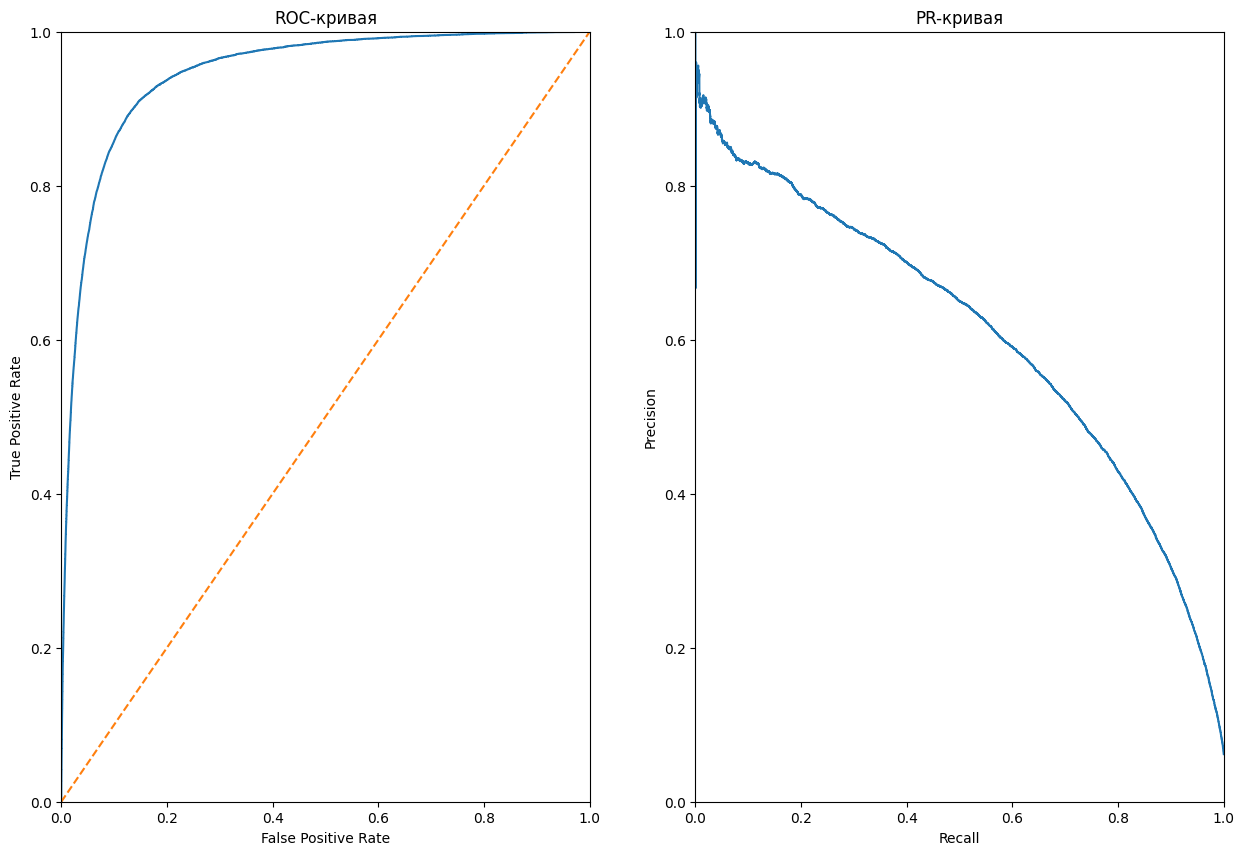

AUROC: 0.95
AUPRC: 0.61


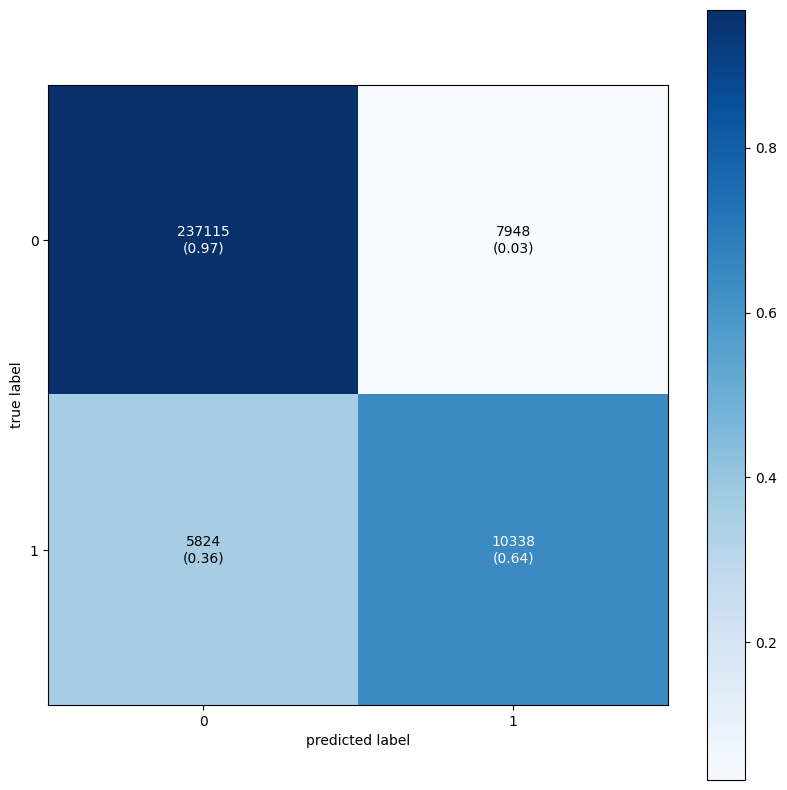

In [37]:
eval_predictions(model, X_train, y_train, X_test, y_test)